# FASE 7

## Preparación y Entrenamiento de la RNN (LSTM / GRU)

### 1️⃣ Datos
- Dataset final: `../../data/processed/final_features_list.csv.gz`  
- Dimensiones: ~44.630 filas × 90 columnas  
- Rango temporal: **2005-01-01 → 2025-10-31**  
- La serie debe reflejar **exactamente la evolución real de la bolsa**  
- Variables principales: precios y retornos de BBVA y Santander + componentes PCA  



### 2️⃣ Modelado
- Modelos a probar: **LSTM** y **GRU**, comparar desempeño  
- Predicción **corto plazo**: 1 a 5 días adelante  
- Entrada principal: **t-1** (opcional incluir t-2, t-3… para patrones más largos)  
- Considerar **descomposición de la serie** (tendencia / estacionalidad / residual)  

### 3️⃣ Preprocesamiento
- Normalización de datos (z-score o min-max) por ventana de entrenamiento  
- Forward-fill / backward-fill para huecos temporales, sin alterar la curva de la serie  
- Opcional: detrending o trabajar solo con la serie residual  
- Preparar secuencias de entrada (`X`) y salida (`y`) para la RNN  

### 4️⃣ Entrenamiento
- Optimizadores: **Adam** o **descenso de gradiente clásico**  
- **Early stopping** para evitar gradientes explosivos o demasiado pequeños  
- Fijar **semilla** para reproducibilidad  
- **Gradient clipping** para evitar explosión de gradientes  
- Posible uso de **scheduler de learning rate**  
- Monitorear métricas: **logloss, accuracy, RMSE, MAPE**  
- Medir y printear **tiempo por epoch y métricas**  
- Visualización de curvas de pérdida y precisión  

### 5️⃣ Validación
- División temporal: **train / validation / test**  
- Validar predicciones en ventanas cortas y por eventos macroeconómicos  
- Predicción **single-step** vs **multi-step** (iterativa o directa)  
- Graficar predicciones vs real, especialmente en picos, crisis y shocks  

### 6️⃣ Experimentación
- Iterar **hiperparámetros**: tamaño de la RNN, número de capas, dropout, learning rate, batch size  
- Decidir si usar **GPU** para acelerar entrenamiento  



### 7️⃣ Notas adicionales
- Mantener consistencia temporal en la normalización y splits  
- Todas las decisiones de imputación o relleno deben preservar la integridad de la curva de mercado  
- Preparar el set final de features (`top_features + PCA components`) listo para RNN  

---


## Plan de Notebook 



### **Parte 1 — Configuración Inicial y Carga de Datos**

**Objetivos:**
- Cargar el dataset final (`final_features_list.csv.gz`)  
- Filtrar por rango temporal 2005–2025  
- Fijar semilla para reproducibilidad  
- Seleccionar columnas principales (BBVA, Santander y PCA)  

**Consideraciones:**
- Mantener la curva de la bolsa **exactamente igual**  
- Dataset ~44.630 × 90 columnas  
- Forward/backward fill solo si hay huecos, sin alterar la serie  



### **Parte 2 — Preprocesamiento y Normalización**

**Objetivos:**
- Escalar variables (z-score o min-max por ventana de entrenamiento)  
- Forward-fill / backward-fill de valores faltantes  
- Opcional: detrending o trabajar con la serie residual  
- Crear features de lag: t-1 (y opcional t-2, t-3…)  
- Preparar `X` y `y` para predicción 1–5 días adelante  
- Guardar set listo para train/validation/test  

**Notas importantes:**
- Mantener integridad temporal  
- No rellenar con medias globales si hay eventos significativos  

### **Parte 3 — División Temporal y Secuencias**

**Objetivos:**
- Dividir en train / validation / test por fechas  
- Crear secuencias deslizantes (`t-1 → t-n`) para la RNN  
- Manejar batchs y padding si hay huecos  
- Preparar secuencias para multi-step prediction (1–5 días)  

**Notas:**
- Validación estrictamente temporal (no shuffle)  
- Mantener consistencia con la curva real de mercado  

### **Parte 4 — Definición del Modelo**

**Objetivos:**
- Definir **LSTM y GRU**  
- Ajustar hiperparámetros: capas, unidades, dropout  
- Optimizador: Adam o SGD  
- Loss function: MSE o RMSE  
- Gradient clipping y early stopping  
- Configurar GPU si disponible  

**Notas:**
- Monitorear logloss, accuracy, RMSE, MAPE  
- Guardar la arquitectura y pesos para comparaciones  

### **Parte 5 — Entrenamiento**

**Objetivos:**
- Entrenar modelo por epochs  
- Mostrar **tiempo por epoch**  
- Imprimir métricas de cada epoch  
- Early stopping basado en validation loss  
- Usar scheduler de learning rate si se estanca  

**Notas:**
- Guardar curvas de loss y accuracy  
- Guardar modelo final entrenado  

### **Parte 6 — Validación y Evaluación**

**Objetivos:**
- Graficar predicciones vs real  
- Comparar single-step vs multi-step  
- Analizar picos, crisis y shocks macroeconómicos  
- Calcular métricas financieras: RMSE, MAPE, Sharpe ratio simulado  

**Notas:**
- Evaluar desempeño por ventanas de 1–5 días  
- Revisar que la predicción siga la curva de mercado exactamente  

### **Parte 7 — Experimentación y Hiperparámetros**

**Objetivos:**
- Iterar sobre unidades, capas, dropout, learning rate, batch size  
- Comparar LSTM vs GRU  
- Analizar resultados por cada combinación de hiperparámetros  
- Preparar conclusiones sobre la mejor configuración  

**Notas:**
- Registrar todos los experimentos y métricas  
- Decidir si usar GPU para acelerar experimentación  


## Código

In [9]:
# ==============================
# Liberries
# ==============================
import pandas as pd
import numpy as np
import random
from IPython.display import display
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
import time
import matplotlib.pyplot as plt

In [4]:
# ==============================
# PARTE 1 — Configuración Inicial y Carga de Datos
# ==============================

# ------------------------------
# 1. Fijar semilla para reproducibilidad
# ------------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# ------------------------------
# 2. Cargar dataset final y poner 'Date' como índice
# ------------------------------
data_path = "../../data/processed/final_data.csv.gz"
data = pd.read_csv(data_path, compression='gzip', parse_dates=['Date'], index_col='Date')

print("Columnas del dataset:", list(data.columns))
print(f"Dimensiones dataset original: {data.shape}")

# ------------------------------
# 3. Filtrar rango temporal
# ------------------------------
start_date = "2005-01-01"
end_date = "2025-10-31"
data = data.loc[start_date:end_date]

print(f"Dimensiones dataset filtrado 2005-2025: {data.shape}")

# ------------------------------
# 4. Seleccionar columnas principales
# ------------------------------
# Columnas de interés para la RNN: precios BBVA, Santander y PCA
pca_cols = [col for col in data.columns if "PCA" in col]
main_cols = ['BBVA.MC_Close', 'SAN.MC_Close'] + pca_cols

data_rnn = data[main_cols]
print(f"Columnas seleccionadas para la RNN: {data_rnn.shape[1]}")

# ------------------------------
# 5. Visualización rápida
# ------------------------------
display(data_rnn)

Columnas del dataset: ['SAN.MC_Close', 'BKT.MC_Low', 'STOXX50E_Low', 'STOXX50E_Open', 'HSBC_Low', 'UNI.MC_Open', 'HSBC_Open', 'EURJPY.csv_Close', 'ECB_M3_SKK', 'IBEX_High', 'BBVA.MC_Low', 'MSCI_Financials.csv_High', 'IBEX_Close', 'SAB.MC_Low', 'UNI.MC_Low', 'EURJPY.csv_Open', 'UNI.MC_High', 'GDAXI_Close', 'URTH_Low', 'URTH_Close', 'GDAXI_Open', 'STOXX50E_Close', 'STOXX50E_High', 'BBVA.MC_Open', 'BKT.MC_Open', 'N225_Open', 'ECB_M3_HKD', 'FTSE_Close', 'EURJPY.csv_Low', 'FTSE_Low', 'UNI.MC_Close', 'JPM_Open', 'IBEX_Low', 'BKT.MC_Close', 'URTH_Open', 'HSBC_Close', 'ECB_M3_USD', 'GDAXI_Low', 'GDAXI_High', 'CABK.MC_Close', 'JPM_Close', 'SAB.MC_Close', 'SAB.MC_High', 'JPM_High', 'SAN.MC_Low', 'MSCI_Financials.csv_Open', 'FTSE_Open', 'BBVA.MC_Close', 'ECB_M3_CZK', 'FTSE_High', 'BBVA.MC_High', 'BKT.MC_High', 'EURJPY.csv_High', 'N225_High', 'SAN.MC_Open', 'MSCI_Financials.csv_Close', 'MSCI_Financials.csv_Low', 'N225_Close', 'URTH_High', 'IBEX_Open', 'ECB_M3_JPY', 'CABK.MC_High', 'CABK.MC_Open', 

,BBVA.MC_Close,SAN.MC_Close,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,NaN,-1.826990,9.380348,-1.741290,3.502204,-0.836790,3.841229,-5.521703,-1.800316,...,0.557657,0.282267,-0.342419,0.156220,-0.129392,0.314089,-0.252011,-1.024318,0.424503,-0.375780
2005-01-02,NaN,NaN,-1.829039,9.372219,-1.740167,3.499036,-0.836139,3.838251,-5.517482,-1.798937,...,0.556834,0.281893,-0.341843,0.155771,-0.129330,0.313644,-0.251855,-1.022809,0.423520,-0.375943
2005-01-03,4.446411,2.599646,13.872782,11.112143,-3.493010,-2.724641,0.472894,-2.873407,-4.582791,1.332656,...,2.515268,1.295396,-1.021902,0.445984,0.216710,-0.171002,0.269162,0.382764,0.353047,-0.440628
2005-01-04,4.422707,2.599646,14.893037,11.396897,-3.324143,-4.069852,0.663474,-2.580715,-5.022860,2.046954,...,1.853438,1.007899,-1.303535,-1.117715,1.556725,-1.142550,0.401012,0.559087,-0.074189,0.690906
2005-01-05,4.399001,2.562912,14.396275,11.309068,-3.677995,-3.095892,0.531848,-2.974937,-4.570563,1.700930,...,2.607476,1.358329,-1.250671,0.216616,0.716502,-0.387861,0.256955,0.455559,0.370632,-0.141541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-29,17.580000,8.865000,28.104901,-13.234004,-7.846998,9.143141,-0.996252,-5.593029,1.942455,-4.821068,...,-1.417439,0.270332,-0.035416,-3.233211,3.800043,-1.273700,1.316176,-4.846464,-0.938750,-0.844075
2025-10-30,17.280001,8.750000,27.821980,-12.739586,-7.443427,8.330550,-0.781672,-5.817917,1.940370,-5.307145,...,-0.837936,0.501435,0.858817,-5.682608,0.919306,0.624927,0.554233,-4.628295,-0.080748,-0.642446
2025-10-30,17.280001,8.750000,27.762862,-12.795248,-7.422621,8.325187,-0.777465,-5.887823,1.912897,-5.162755,...,-0.739295,0.549786,0.778913,-5.656696,0.947402,0.721576,0.793313,-4.729327,-0.076427,-0.544759


In [6]:
# ==============================
# PARTE 2 — Preprocesamiento y Preparación de Secuencias (TF)
# ==============================

# ------------------------------
# 1. Forward-fill / Backward-fill por si hay NaN
# ------------------------------
data_rnn = data_rnn.ffill().bfill()

# ------------------------------
# 2. Escalado de datos
# ------------------------------
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_rnn), 
                           columns=data_rnn.columns, index=data_rnn.index)

# ------------------------------
# 3. Función para crear secuencias
# ------------------------------
def create_sequences(data, target_cols=['BBVA.MC_Close', 'SAN.MC_Close'], 
                     lookback=5, horizon=1):
    X, y = [], []
    for i in range(lookback, len(data) - horizon + 1):
        X_seq = data.iloc[i - lookback:i].values
        y_seq = data.iloc[i:i + horizon][target_cols].values  # multi-step support
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# ------------------------------
# 4. Crear secuencias para single-step y multi-step
# ------------------------------
lookback = 5  # t-1 a t-5

# Single-step (1 día adelante)
horizon = 1
X_1, y_1 = create_sequences(data_scaled, lookback=lookback, horizon=horizon)

# Multi-step (5 días adelante)
horizon = 5
X_5, y_5 = create_sequences(data_scaled, lookback=lookback, horizon=horizon)

# ------------------------------
# 5. Información de shapes
# ------------------------------
print("Single-step prediction:")
print("X_1.shape:", X_1.shape)  # (samples, 5, n_features)
print("y_1.shape:", y_1.shape)  # (samples, 1, target_cols)

print("\nMulti-step prediction (5 días):")
print("X_5.shape:", X_5.shape)
print("y_5.shape:", y_5.shape)

Single-step prediction:
X_1.shape: (9520, 5, 24)
y_1.shape: (9520, 1, 2)

Multi-step prediction (5 días):
X_5.shape: (9516, 5, 24)
y_5.shape: (9516, 5, 2)


# Pruebas

## Prueba 1

Input shape: (5, 24), Output size: 2

=== Entrenando LSTM_units64_drop0.2_bs32 ===


c:\Proyectos - UAX\CRR-Prediccion_acciones\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 - tiempo: 1.91s - loss: 0.045684 - val_loss: 1.357971 - mae: 0.146227 - val_mae: 0.821251
Epoch 2 - tiempo: 0.66s - loss: 0.013361 - val_loss: 1.139010 - mae: 0.087719 - val_mae: 0.729505
Epoch 3 - tiempo: 0.63s - loss: 0.009641 - val_loss: 1.042811 - mae: 0.074089 - val_mae: 0.673585
Epoch 4 - tiempo: 0.63s - loss: 0.008292 - val_loss: 0.998748 - mae: 0.068177 - val_mae: 0.650823
Epoch 5 - tiempo: 0.63s - loss: 0.007372 - val_loss: 0.993747 - mae: 0.064277 - val_mae: 0.654180
Epoch 6 - tiempo: 0.62s - loss: 0.006532 - val_loss: 0.976762 - mae: 0.059926 - val_mae: 0.637767
Epoch 7 - tiempo: 0.64s - loss: 0.006109 - val_loss: 0.953302 - mae: 0.058101 - val_mae: 0.628239
Epoch 8 - tiempo: 0.63s - loss: 0.005686 - val_loss: 0.969668 - mae: 0.055826 - val_mae: 0.636210
Epoch 9 - tiempo: 0.63s - loss: 0.005341 - val_loss: 0.988640 - mae: 0.053893 - val_mae: 0.638729
Epoch 10 - tiempo: 0.63s - loss: 0.005109 - val_loss: 1.024283 - mae: 0.052830 - val_mae: 0.649385
Epoch 11 - tiempo: 

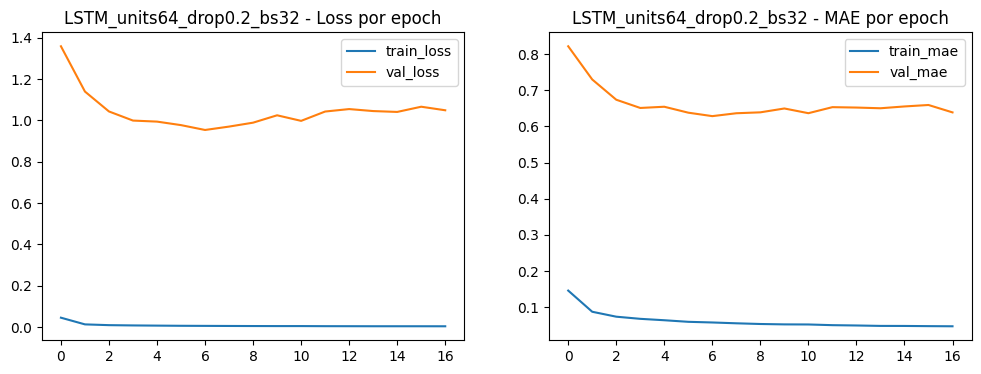

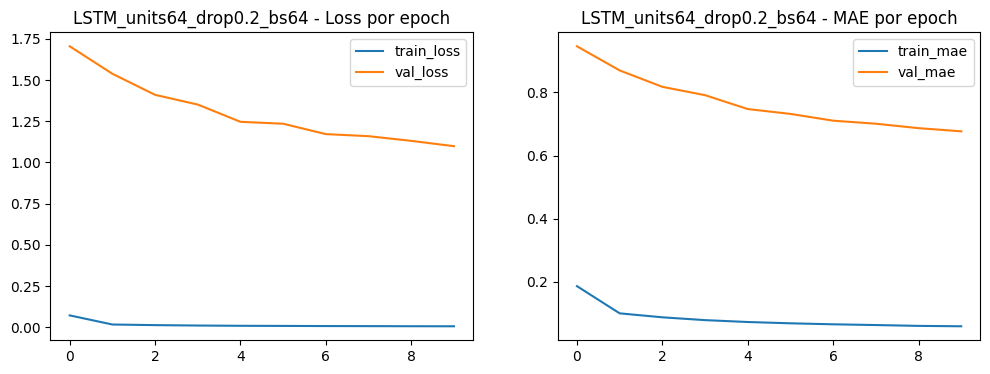

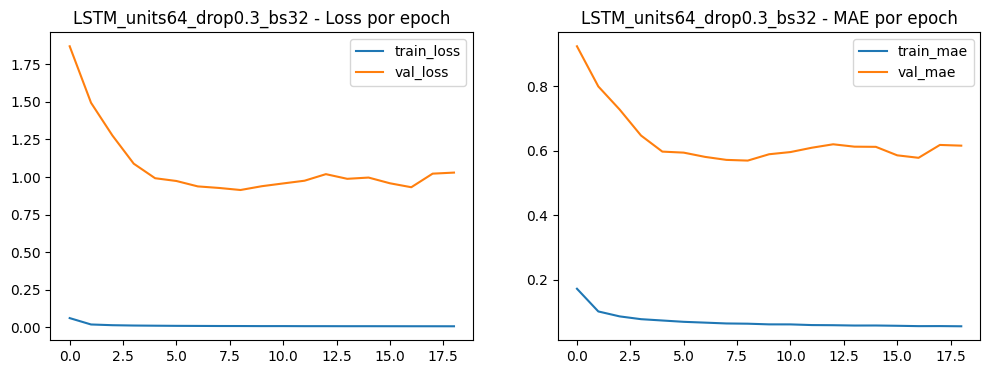

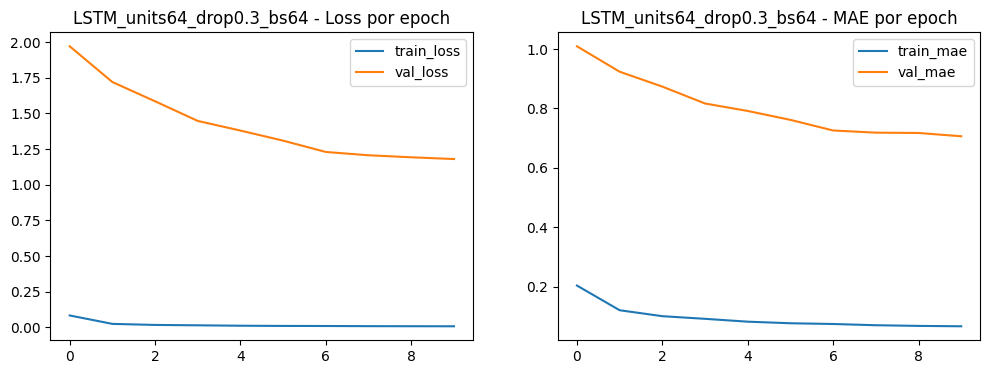

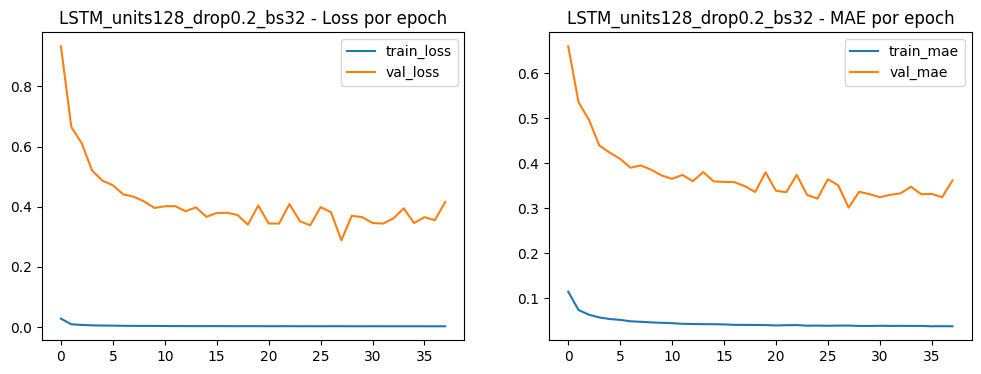

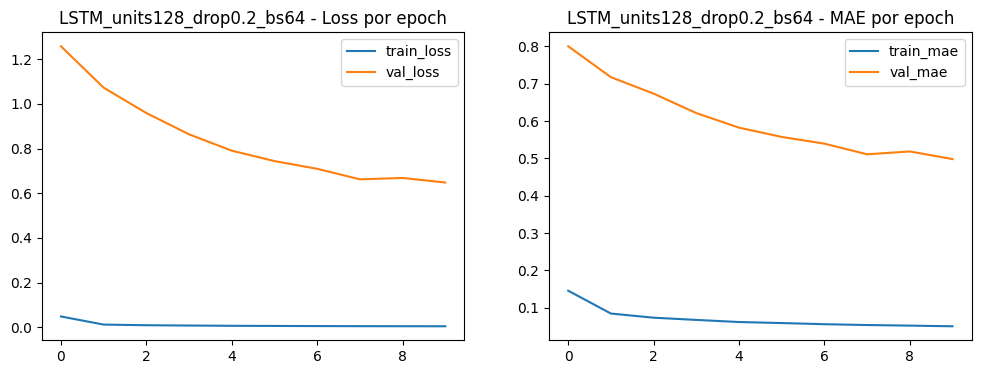

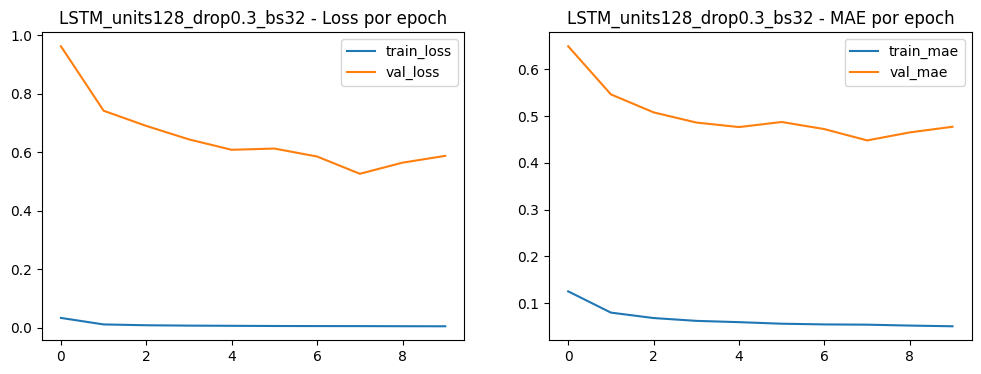

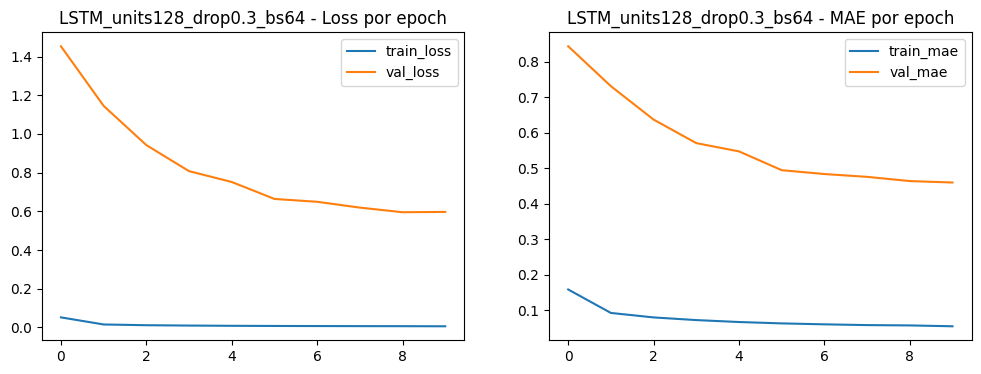

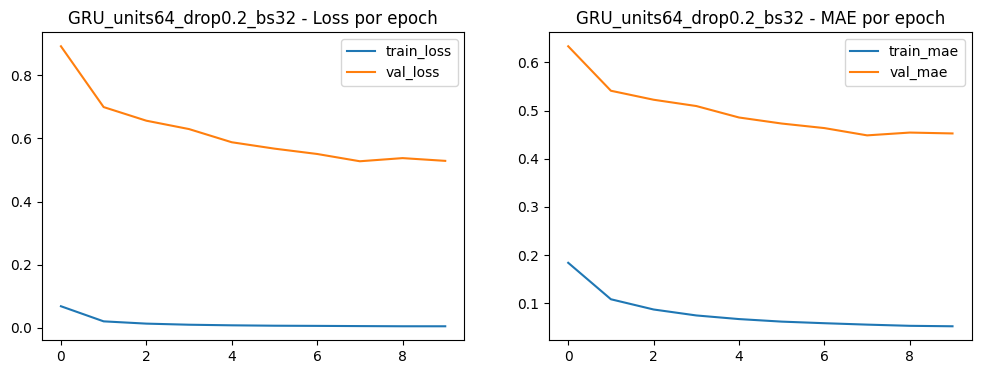

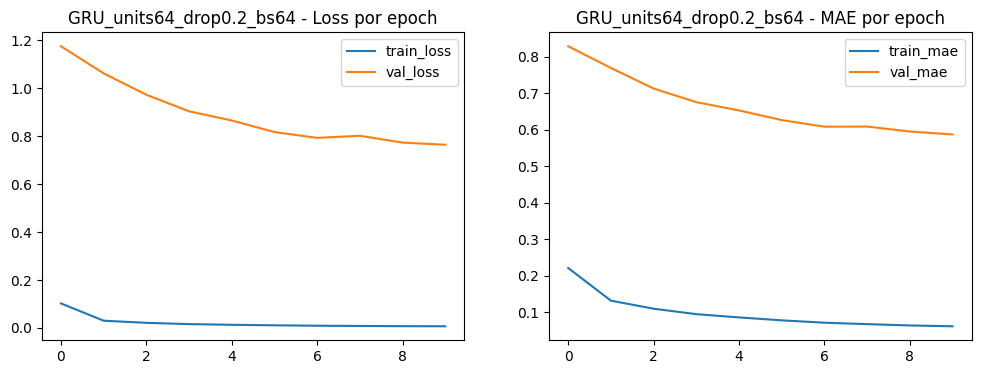

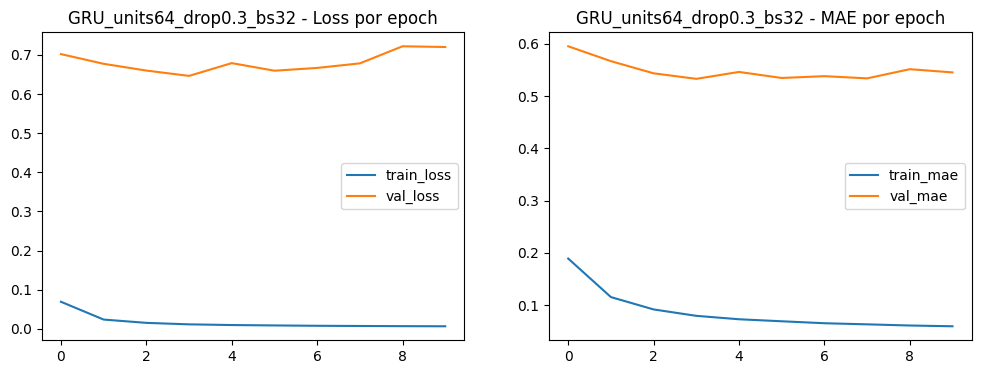

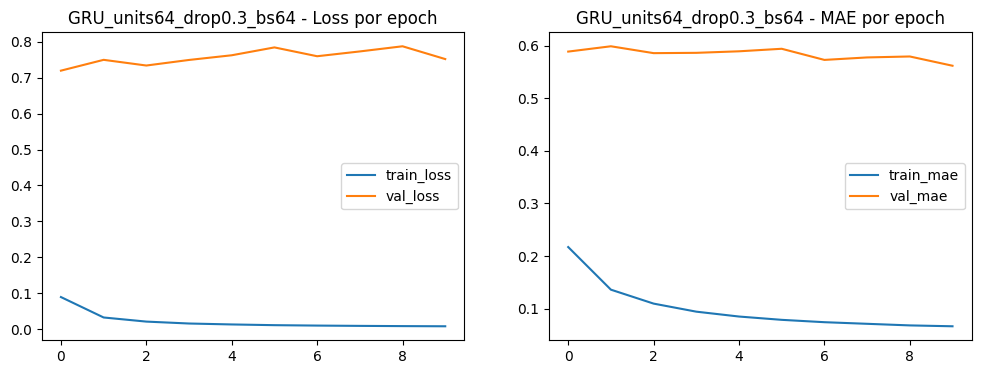

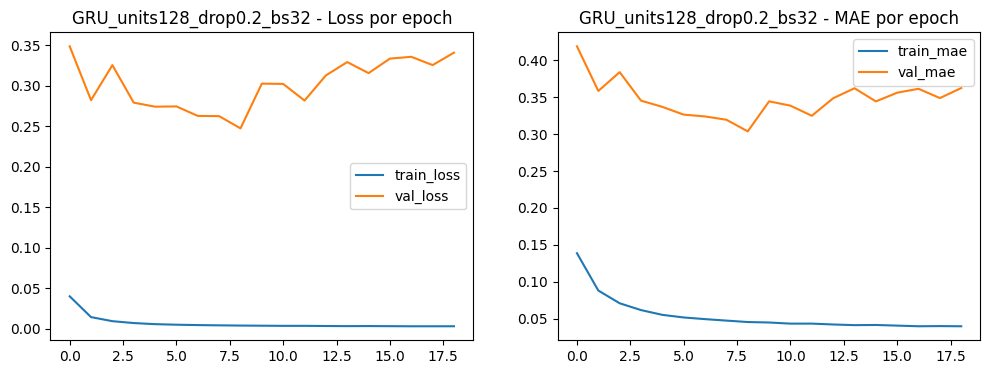

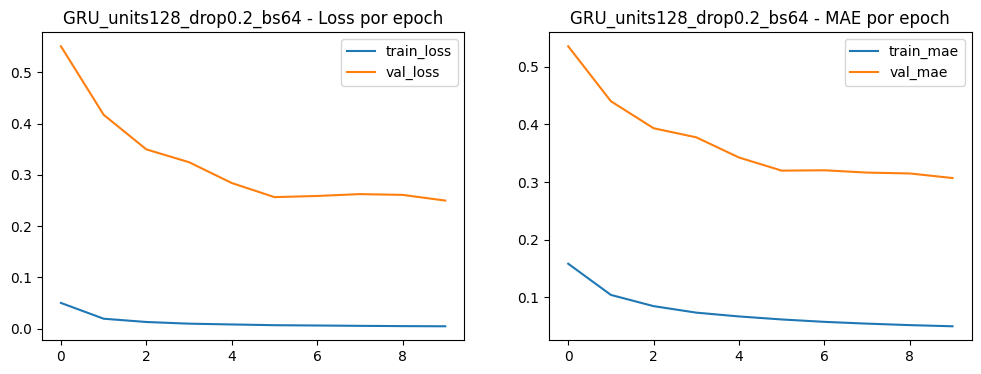

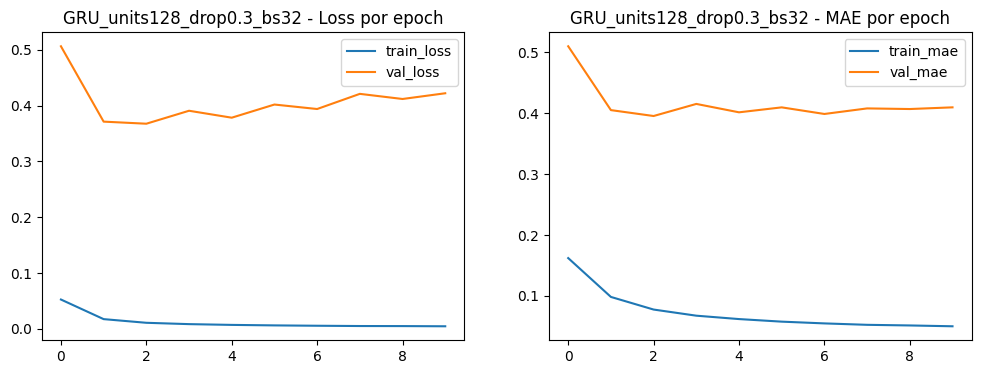

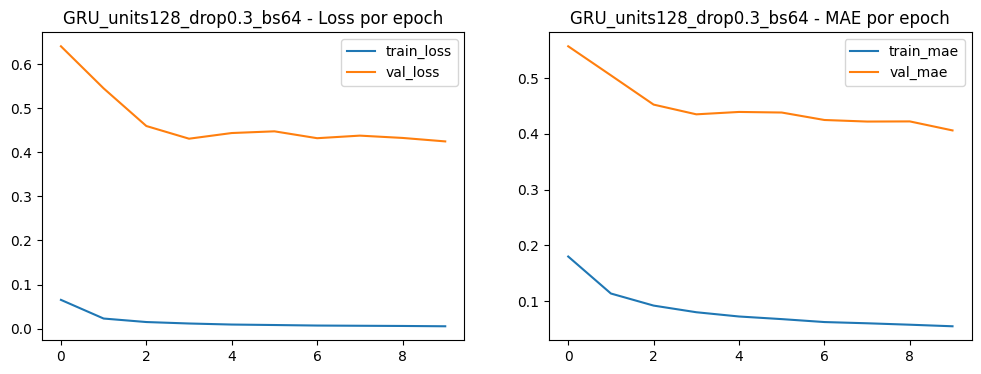

In [11]:
# ==============================
# PARTE 3 — Construcción y Entrenamiento de la RNN (LSTM / GRU)
# ==============================

import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
import matplotlib.pyplot as plt

# ------------------------------
# 1. Elegir horizonte: single-step o multi-step
# ------------------------------
# Para single-step:
X, y = X_1, y_1
# Para multi-step (5 días):
# X, y = X_5, y_5

# Aplanar y para Keras
y = y.reshape(y.shape[0], -1)

input_shape = (X.shape[1], X.shape[2])
output_size = y.shape[1]

print(f"Input shape: {input_shape}, Output size: {output_size}")

# ------------------------------
# 2. Callback para tiempo por epoch
# ------------------------------
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.epoch_time_start
        self.times.append(elapsed)
        print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

time_callback = TimeHistory()

# ------------------------------
# 3. Función para construir RNN
# ------------------------------
def build_rnn(input_shape, output_size, rnn_type='LSTM', units=64, dropout=0.2):
    model = Sequential()
    if rnn_type == 'LSTM':
        model.add(LSTM(units, input_shape=input_shape))
    elif rnn_type == 'GRU':
        model.add(GRU(units, input_shape=input_shape))
    else:
        raise ValueError("rnn_type debe ser 'LSTM' o 'GRU'")
    model.add(Dropout(dropout))
    model.add(Dense(output_size))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# ------------------------------
# 4. Early stopping
# ------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ------------------------------
# 5. Hiperparámetros a iterar
# ------------------------------
rnn_types = ['LSTM', 'GRU']
units_list = [64, 128]
dropout_list = [0.2, 0.3]
batch_sizes = [32, 64]

histories = {}

# ------------------------------
# 6. Entrenamiento iterativo
# ------------------------------
for rnn_type in rnn_types:
    for units in units_list:
        for dropout in dropout_list:
            for batch_size in batch_sizes:
                name = f"{rnn_type}_units{units}_drop{dropout}_bs{batch_size}"
                print(f"\n=== Entrenando {name} ===")
                
                model = build_rnn(input_shape, output_size, rnn_type=rnn_type, units=units, dropout=dropout)
                
                start_time = time.time()
                history = model.fit(
                    X, y,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks=[early_stop, time_callback],
                    verbose=0
                )
                end_time = time.time()
                print(f"Tiempo total entrenamiento {name}: {end_time - start_time:.2f}s")
                
                histories[name] = history

# ------------------------------
# 7. Graficar métricas
# ------------------------------
for key, history in histories.items():
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"{key} - Loss por epoch")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['mae'], label='train_mae')
    plt.plot(history.history['val_mae'], label='val_mae')
    plt.title(f"{key} - MAE por epoch")
    plt.legend()
    
    plt.show()


## Prueba 2

Epoch 1 - tiempo: 2.26s - loss: 0.062868 - val_loss: 0.881535 - mae: 0.129690 - val_mae: 0.640755
Epoch 2 - tiempo: 0.86s - loss: 0.022115 - val_loss: 0.615934 - mae: 0.080177 - val_mae: 0.501569
Epoch 3 - tiempo: 0.84s - loss: 0.013921 - val_loss: 0.497799 - mae: 0.067013 - val_mae: 0.443381
Epoch 4 - tiempo: 0.86s - loss: 0.011000 - val_loss: 0.407898 - mae: 0.062357 - val_mae: 0.393026
Epoch 5 - tiempo: 0.90s - loss: 0.009163 - val_loss: 0.389556 - mae: 0.058681 - val_mae: 0.386831
Epoch 6 - tiempo: 0.86s - loss: 0.008200 - val_loss: 0.375057 - mae: 0.056930 - val_mae: 0.383028
Epoch 7 - tiempo: 0.93s - loss: 0.007429 - val_loss: 0.302965 - mae: 0.054548 - val_mae: 0.353590
Epoch 8 - tiempo: 0.87s - loss: 0.007487 - val_loss: 0.258551 - mae: 0.055375 - val_mae: 0.321674
Epoch 9 - tiempo: 0.88s - loss: 0.007221 - val_loss: 0.284636 - mae: 0.054241 - val_mae: 0.345909
Epoch 10 - tiempo: 0.89s - loss: 0.006835 - val_loss: 0.249105 - mae: 0.052992 - val_mae: 0.320470
Epoch 11 - tiempo: 

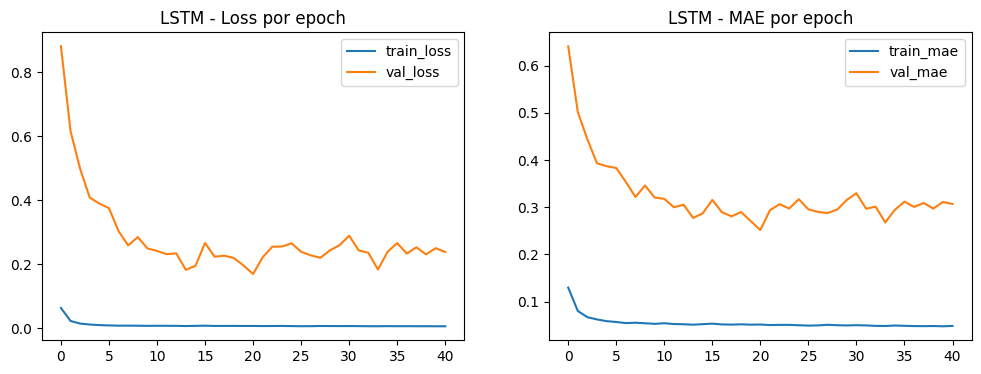

In [12]:
# ==============================
# PARTE 3 — Construcción y Entrenamiento de la RNN (LSTM / GRU) Ajustada
# ==============================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import time
import matplotlib.pyplot as plt

# ------------------------------
# Callback para tiempo por epoch
# ------------------------------
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.epoch_time_start
        self.times.append(elapsed)
        print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

time_callback = TimeHistory()

# ------------------------------
# Función para construir RNN ajustada
# ------------------------------
def build_rnn(input_shape, output_size, rnn_type='LSTM', units=64, dropout=0.3, l2_reg=0.001):
    model = Sequential()
    
    if rnn_type == 'LSTM':
        model.add(LSTM(units, input_shape=input_shape, 
                       kernel_regularizer=regularizers.l2(l2_reg)))
    elif rnn_type == 'GRU':
        model.add(GRU(units, input_shape=input_shape, 
                      kernel_regularizer=regularizers.l2(l2_reg)))
    else:
        raise ValueError("rnn_type debe ser 'LSTM' o 'GRU'")
    
    model.add(Dropout(dropout))
    model.add(Dense(output_size))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ------------------------------
# Early stopping más tolerante
# ------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# ------------------------------
# Selección de hiperparámetros base
# ------------------------------
rnn_type = 'LSTM'
units = 128
dropout = 0.3
batch_size = 32

# ------------------------------
# Selección de datos (ejemplo single-step, multi-step puedes repetir)
# ------------------------------
X_train, y_train = X_1, y_1.reshape(X_1.shape[0], -1)  # single-step aplanado
# Para multi-step: X_5, y_5.reshape(X_5.shape[0], -1)

input_shape = (X_train.shape[1], X_train.shape[2])
output_size = y_train.shape[1]

# ------------------------------
# Construir modelo
# ------------------------------
model = build_rnn(input_shape, output_size, rnn_type=rnn_type, units=units, dropout=dropout)

# ------------------------------
# Entrenamiento
# ------------------------------
start_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stop, time_callback],
    verbose=0
)
end_time = time.time()
print(f"Tiempo total entrenamiento: {end_time - start_time:.2f}s")

# ------------------------------
# Graficar métricas
# ------------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title(f"{rnn_type} - Loss por epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.title(f"{rnn_type} - MAE por epoch")
plt.legend()

plt.show()


## Prueba 3

In [13]:
# ==============================
# ENTRENAMIENTO MULTI-HIPERPARÁMETROS RNN/LSTM
# ==============================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import time
import itertools
import pandas as pd

# ------------------------------
# Callback para imprimir métricas y tiempo por epoch
# ------------------------------
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.epoch_time_start
        self.times.append(elapsed)
        print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

# ------------------------------
# Función para construir RNN
# ------------------------------
def build_rnn(input_shape, output_size, rnn_type='LSTM', units=64, dropout=0.2, l2_reg=0.001):
    model = Sequential()
    if rnn_type == 'LSTM':
        model.add(LSTM(units, input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_reg)))
    elif rnn_type == 'GRU':
        model.add(GRU(units, input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_reg)))
    else:
        raise ValueError("rnn_type debe ser 'LSTM' o 'GRU'")
    model.add(Dropout(dropout))
    model.add(Dense(output_size))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ------------------------------
# EarlyStopping
# ------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# ------------------------------
# Hiperparámetros a iterar
# ------------------------------
rnn_types = ['LSTM', 'GRU']
units_list = [64, 128]
dropouts = [0.2, 0.3]
batch_sizes = [32, 64]

# ------------------------------
# Preparar datos
# ------------------------------
# Suponiendo que ya tienes X_train y y_train
input_shape = (X_train.shape[1], X_train.shape[2])
output_size = y_train.shape[1]

# ------------------------------
# Guardar resultados
# ------------------------------
results = []

# ------------------------------
# Iterar combinaciones
# ------------------------------
for rnn_type, units, dropout, batch_size in itertools.product(rnn_types, units_list, dropouts, batch_sizes):
    print(f"\n=== Entrenando {rnn_type}_units{units}_drop{dropout}_bs{batch_size} ===")
    
    model = build_rnn(input_shape, output_size, rnn_type=rnn_type, units=units, dropout=dropout)
    time_callback = TimeHistory()
    
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=1000,       # entrenar mucho más
        batch_size=batch_size,
        callbacks=[early_stop, time_callback],
        verbose=0
    )
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Tiempo total entrenamiento {rnn_type}_units{units}_drop{dropout}_bs{batch_size}: {total_time:.2f}s")
    
    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss) + 1
    
    # Guardar resultados
    results.append({
        'model': f"{rnn_type}_units{units}_drop{dropout}_bs{batch_size}",
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch,
        'history': history,
        'model_object': model
    })

# ------------------------------
# Mostrar top 5 modelos por val_loss
# ------------------------------
results_df = pd.DataFrame(results)
top5 = results_df.sort_values(by='best_val_loss').head(5)

print("\n=== TOP 5 MODELOS ===")
for i, row in top5.iterrows():
    print(f"{row['model']} - Best val_loss: {row['best_val_loss']:.6f} en epoch {row['best_epoch']}")



=== Entrenando LSTM_units64_drop0.2_bs32 ===
Epoch 1 - tiempo: 1.96s - loss: 0.073164 - val_loss: 1.630839 - mae: 0.143185 - val_mae: 0.918907
Epoch 2 - tiempo: 0.64s - loss: 0.026743 - val_loss: 1.204415 - mae: 0.086597 - val_mae: 0.758341
Epoch 3 - tiempo: 0.64s - loss: 0.016485 - val_loss: 1.017177 - mae: 0.071905 - val_mae: 0.682415
Epoch 4 - tiempo: 0.64s - loss: 0.012153 - val_loss: 0.867392 - mae: 0.064660 - val_mae: 0.616096
Epoch 5 - tiempo: 0.64s - loss: 0.010184 - val_loss: 0.794705 - mae: 0.061144 - val_mae: 0.574923
Epoch 6 - tiempo: 0.64s - loss: 0.008835 - val_loss: 0.719261 - mae: 0.057986 - val_mae: 0.544266
Epoch 7 - tiempo: 0.64s - loss: 0.008107 - val_loss: 0.661287 - mae: 0.056738 - val_mae: 0.512326
Epoch 8 - tiempo: 0.63s - loss: 0.007306 - val_loss: 0.617622 - mae: 0.054410 - val_mae: 0.499860
Epoch 9 - tiempo: 0.64s - loss: 0.007286 - val_loss: 0.551097 - mae: 0.054478 - val_mae: 0.461282
Epoch 10 - tiempo: 0.64s - loss: 0.006914 - val_loss: 0.549968 - mae: 0.

## Prueba 4


=== Entrenando LSTM_units128_drop0.2_bs32 ===
Epoch 1 - tiempo: 2.47s - loss: 0.055239 - val_loss: 0.931485 - mae: 0.115309 - val_mae: 0.663355
Epoch 2 - tiempo: 0.86s - loss: 0.019417 - val_loss: 0.652759 - mae: 0.071769 - val_mae: 0.527813
Epoch 3 - tiempo: 0.88s - loss: 0.012532 - val_loss: 0.534306 - mae: 0.061517 - val_mae: 0.472747
Epoch 4 - tiempo: 0.85s - loss: 0.010076 - val_loss: 0.424980 - mae: 0.057672 - val_mae: 0.423140
Epoch 5 - tiempo: 0.87s - loss: 0.007943 - val_loss: 0.374226 - mae: 0.052669 - val_mae: 0.380489
Epoch 6 - tiempo: 0.87s - loss: 0.007040 - val_loss: 0.294000 - mae: 0.050983 - val_mae: 0.341964
Epoch 7 - tiempo: 0.84s - loss: 0.006651 - val_loss: 0.256085 - mae: 0.049786 - val_mae: 0.316355
Epoch 8 - tiempo: 0.87s - loss: 0.006075 - val_loss: 0.255240 - mae: 0.048372 - val_mae: 0.318426
Epoch 9 - tiempo: 0.94s - loss: 0.006228 - val_loss: 0.243573 - mae: 0.048919 - val_mae: 0.316350
Epoch 10 - tiempo: 0.92s - loss: 0.006026 - val_loss: 0.224520 - mae: 0

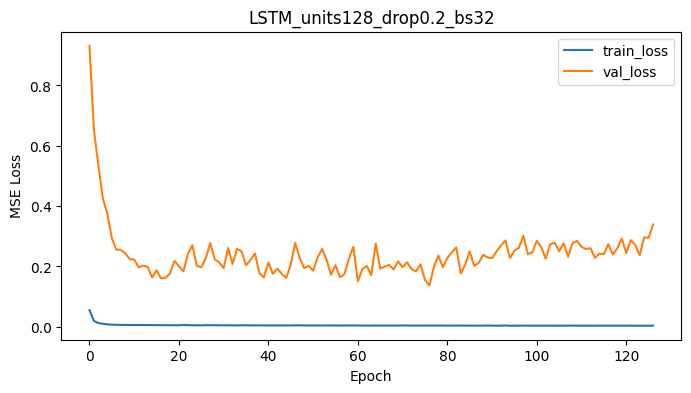


=== Entrenando LSTM_units128_drop0.25_bs32 ===
Epoch 1 - tiempo: 2.03s - loss: 0.057522 - val_loss: 0.827466 - mae: 0.120091 - val_mae: 0.609386
Epoch 2 - tiempo: 0.81s - loss: 0.020583 - val_loss: 0.599479 - mae: 0.075841 - val_mae: 0.510697
Epoch 3 - tiempo: 0.81s - loss: 0.012826 - val_loss: 0.483668 - mae: 0.063007 - val_mae: 0.451451
Epoch 4 - tiempo: 0.81s - loss: 0.010218 - val_loss: 0.409602 - mae: 0.059020 - val_mae: 0.407426
Epoch 5 - tiempo: 0.81s - loss: 0.008452 - val_loss: 0.366119 - mae: 0.055430 - val_mae: 0.393620
Epoch 6 - tiempo: 0.81s - loss: 0.007701 - val_loss: 0.296994 - mae: 0.054188 - val_mae: 0.355461
Epoch 7 - tiempo: 0.82s - loss: 0.007309 - val_loss: 0.296302 - mae: 0.053268 - val_mae: 0.349562
Epoch 8 - tiempo: 0.81s - loss: 0.006815 - val_loss: 0.244591 - mae: 0.051842 - val_mae: 0.319929
Epoch 9 - tiempo: 0.81s - loss: 0.006767 - val_loss: 0.246751 - mae: 0.051824 - val_mae: 0.323057
Epoch 10 - tiempo: 0.81s - loss: 0.006775 - val_loss: 0.214155 - mae: 

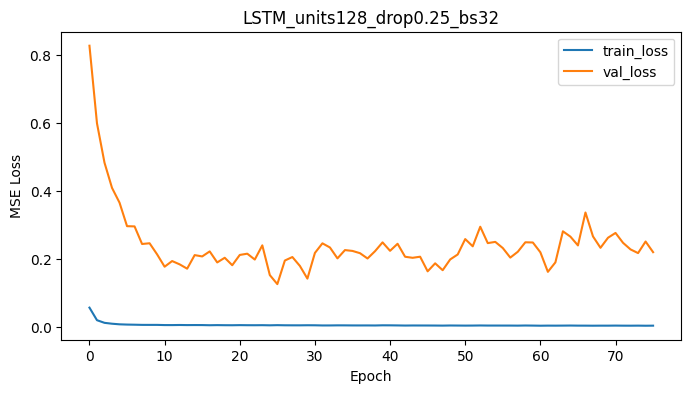


=== Entrenando LSTM_units128_drop0.3_bs32 ===
Epoch 1 - tiempo: 2.07s - loss: 0.056034 - val_loss: 0.736767 - mae: 0.120239 - val_mae: 0.569960
Epoch 2 - tiempo: 0.81s - loss: 0.020142 - val_loss: 0.531066 - mae: 0.076878 - val_mae: 0.469638
Epoch 3 - tiempo: 0.83s - loss: 0.012856 - val_loss: 0.427838 - mae: 0.065510 - val_mae: 0.418765
Epoch 4 - tiempo: 0.82s - loss: 0.010298 - val_loss: 0.433821 - mae: 0.060266 - val_mae: 0.414398
Epoch 5 - tiempo: 0.83s - loss: 0.009284 - val_loss: 0.358375 - mae: 0.059118 - val_mae: 0.370734
Epoch 6 - tiempo: 0.83s - loss: 0.008101 - val_loss: 0.311123 - mae: 0.056235 - val_mae: 0.346323
Epoch 7 - tiempo: 0.83s - loss: 0.007096 - val_loss: 0.298165 - mae: 0.053370 - val_mae: 0.349164
Epoch 8 - tiempo: 0.83s - loss: 0.007063 - val_loss: 0.251835 - mae: 0.054194 - val_mae: 0.311955
Epoch 9 - tiempo: 0.82s - loss: 0.007579 - val_loss: 0.237512 - mae: 0.055344 - val_mae: 0.310537
Epoch 10 - tiempo: 0.85s - loss: 0.007074 - val_loss: 0.257515 - mae: 0

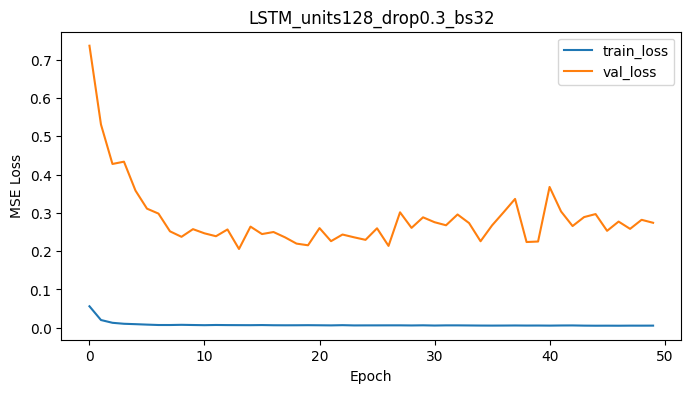


=== Entrenando GRU_units128_drop0.2_bs32 ===
Epoch 1 - tiempo: 2.16s - loss: 0.075286 - val_loss: 0.471378 - mae: 0.147398 - val_mae: 0.474232
Epoch 2 - tiempo: 0.80s - loss: 0.027666 - val_loss: 0.302740 - mae: 0.087550 - val_mae: 0.360379
Epoch 3 - tiempo: 0.79s - loss: 0.018283 - val_loss: 0.249669 - mae: 0.069942 - val_mae: 0.326753
Epoch 4 - tiempo: 0.78s - loss: 0.013127 - val_loss: 0.219297 - mae: 0.059826 - val_mae: 0.307357
Epoch 5 - tiempo: 0.82s - loss: 0.010287 - val_loss: 0.180428 - mae: 0.054637 - val_mae: 0.270300
Epoch 6 - tiempo: 0.80s - loss: 0.008553 - val_loss: 0.151754 - mae: 0.051713 - val_mae: 0.256425
Epoch 7 - tiempo: 0.80s - loss: 0.007604 - val_loss: 0.144883 - mae: 0.049144 - val_mae: 0.237268
Epoch 8 - tiempo: 0.78s - loss: 0.006757 - val_loss: 0.109831 - mae: 0.048043 - val_mae: 0.212374
Epoch 9 - tiempo: 0.78s - loss: 0.006706 - val_loss: 0.111061 - mae: 0.048206 - val_mae: 0.218628
Epoch 10 - tiempo: 0.79s - loss: 0.006481 - val_loss: 0.098071 - mae: 0.

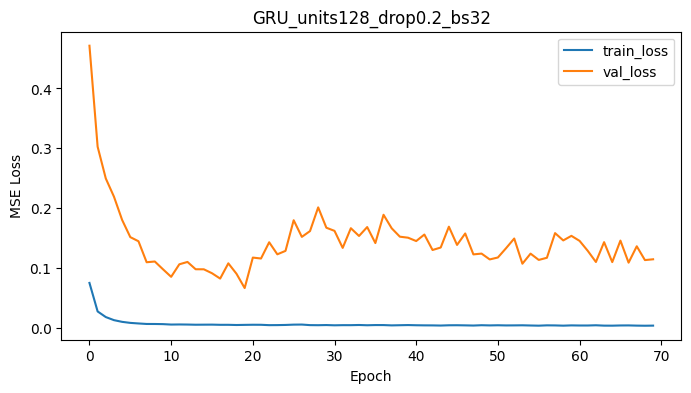


=== Entrenando GRU_units128_drop0.25_bs32 ===
Epoch 1 - tiempo: 2.13s - loss: 0.072750 - val_loss: 0.488823 - mae: 0.148574 - val_mae: 0.468309
Epoch 2 - tiempo: 0.81s - loss: 0.029617 - val_loss: 0.321008 - mae: 0.091890 - val_mae: 0.365740
Epoch 3 - tiempo: 0.78s - loss: 0.018872 - val_loss: 0.247420 - mae: 0.071672 - val_mae: 0.322169
Epoch 4 - tiempo: 0.79s - loss: 0.013908 - val_loss: 0.220636 - mae: 0.061982 - val_mae: 0.299870
Epoch 5 - tiempo: 0.79s - loss: 0.011253 - val_loss: 0.176487 - mae: 0.056853 - val_mae: 0.266794
Epoch 6 - tiempo: 0.79s - loss: 0.009470 - val_loss: 0.185594 - mae: 0.054183 - val_mae: 0.267177
Epoch 7 - tiempo: 0.80s - loss: 0.007999 - val_loss: 0.168981 - mae: 0.051491 - val_mae: 0.249259
Epoch 8 - tiempo: 0.80s - loss: 0.007367 - val_loss: 0.160091 - mae: 0.050872 - val_mae: 0.268916
Epoch 9 - tiempo: 0.81s - loss: 0.006893 - val_loss: 0.123257 - mae: 0.050269 - val_mae: 0.219305
Epoch 10 - tiempo: 0.80s - loss: 0.006336 - val_loss: 0.108948 - mae: 0

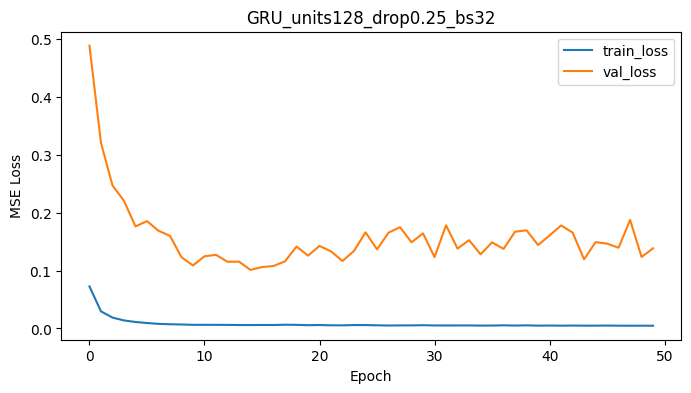


=== Entrenando GRU_units128_drop0.3_bs32 ===
Epoch 1 - tiempo: 2.08s - loss: 0.074809 - val_loss: 0.433606 - mae: 0.154824 - val_mae: 0.436755
Epoch 2 - tiempo: 0.80s - loss: 0.030602 - val_loss: 0.303630 - mae: 0.093984 - val_mae: 0.352940
Epoch 3 - tiempo: 0.80s - loss: 0.020046 - val_loss: 0.265702 - mae: 0.075859 - val_mae: 0.341902
Epoch 4 - tiempo: 0.80s - loss: 0.014634 - val_loss: 0.217923 - mae: 0.064954 - val_mae: 0.299214
Epoch 5 - tiempo: 0.79s - loss: 0.011615 - val_loss: 0.202855 - mae: 0.059240 - val_mae: 0.283067
Epoch 6 - tiempo: 0.81s - loss: 0.009914 - val_loss: 0.187478 - mae: 0.057217 - val_mae: 0.271246
Epoch 7 - tiempo: 0.80s - loss: 0.008672 - val_loss: 0.167661 - mae: 0.053652 - val_mae: 0.259143
Epoch 8 - tiempo: 0.79s - loss: 0.007744 - val_loss: 0.194543 - mae: 0.052712 - val_mae: 0.288938
Epoch 9 - tiempo: 0.79s - loss: 0.007506 - val_loss: 0.137094 - mae: 0.052208 - val_mae: 0.222595
Epoch 10 - tiempo: 0.83s - loss: 0.006891 - val_loss: 0.145090 - mae: 0.

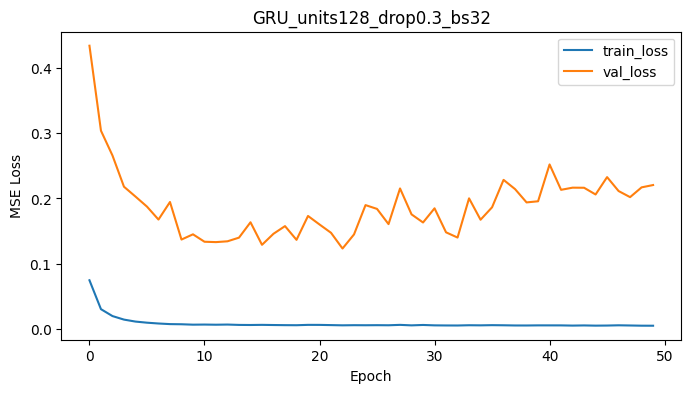


=== TOP 5 MODELOS ===
GRU_units128_drop0.2_bs32 - Best val_loss: 0.066711 en epoch 20
GRU_units128_drop0.25_bs32 - Best val_loss: 0.101301 en epoch 15
GRU_units128_drop0.3_bs32 - Best val_loss: 0.123352 en epoch 23
LSTM_units128_drop0.25_bs32 - Best val_loss: 0.126603 en epoch 26
LSTM_units128_drop0.2_bs32 - Best val_loss: 0.136722 en epoch 77


In [14]:
# ==============================
# ENTRENAMIENTO MULTI-HIPERPARÁMETROS RNN/LSTM/GRU
# ==============================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import time
import itertools
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# Callback para imprimir métricas y tiempo por epoch
# ------------------------------
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.epoch_time_start
        self.times.append(elapsed)
        print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - "
              f"loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - "
              f"mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

# ------------------------------
# Función para construir RNN
# ------------------------------
def build_rnn(input_shape, output_size, rnn_type='LSTM', units=64, dropout=0.2, l2_reg=0.001):
    model = Sequential()
    if rnn_type == 'LSTM':
        model.add(LSTM(units, input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_reg)))
    elif rnn_type == 'GRU':
        model.add(GRU(units, input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_reg)))
    else:
        raise ValueError("rnn_type debe ser 'LSTM' o 'GRU'")
    model.add(Dropout(dropout))
    model.add(Dense(output_size))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ------------------------------
# EarlyStopping
# ------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# ------------------------------
# Hiperparámetros a iterar
# ------------------------------
rnn_types = ['LSTM', 'GRU']
units_list = [128]          # centrarse en los mejores
dropouts = [0.2, 0.25, 0.3] # refinar dropout
batch_sizes = [32]          # batch 32 da mejores resultados

# ------------------------------
# Preparar datos
# ------------------------------
input_shape = (X_train.shape[1], X_train.shape[2])
output_size = y_train.shape[1]

# ------------------------------
# Guardar resultados
# ------------------------------
results = []

# ------------------------------
# Iterar combinaciones
# ------------------------------
for rnn_type, units, dropout, batch_size in itertools.product(rnn_types, units_list, dropouts, batch_sizes):
    print(f"\n=== Entrenando {rnn_type}_units{units}_drop{dropout}_bs{batch_size} ===")
    
    model = build_rnn(input_shape, output_size, rnn_type=rnn_type, units=units, dropout=dropout)
    time_callback = TimeHistory()
    
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=500,  # más tiempo
        batch_size=batch_size,
        callbacks=[early_stop, time_callback],
        verbose=0
    )
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Tiempo total entrenamiento {rnn_type}_units{units}_drop{dropout}_bs{batch_size}: {total_time:.2f}s")
    
    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss) + 1
    
    # Guardar resultados
    results.append({
        'model': f"{rnn_type}_units{units}_drop{dropout}_bs{batch_size}",
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch,
        'history': history,
        'model_object': model
    })

    # ------------------------------
    # Graficar loss y val_loss por modelo
    # ------------------------------
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"{rnn_type}_units{units}_drop{dropout}_bs{batch_size}")
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

# ------------------------------
# Mostrar top 5 modelos por val_loss
# ------------------------------
results_df = pd.DataFrame(results)
top5 = results_df.sort_values(by='best_val_loss').head(5)

print("\n=== TOP 5 MODELOS ===")
for i, row in top5.iterrows():
    print(f"{row['model']} - Best val_loss: {row['best_val_loss']:.6f} en epoch {row['best_epoch']}")
